In [5]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [6]:
plots = [("traces/normal/", 'grid9_normal_2019-02-13_17:05'),
         ("traces/1bh-3/", 'grid9_1bh-3_2019-02-13_16:28'),
         ("traces/1bh-5/", 'grid9_1bh-5_2019-02-13_15:31'),
         ("traces/1bh-6/", 'grid9_1bh-6_2019-02-13_12:59'),
         ("traces/1bh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1bh-9/", 'grid9_1bh-9_2019-02-13_15:57'),
         ("traces/1gh-3/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-5/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-6/", 'grid_1gh-6_2019-02-15_18:25'),
         ("traces/1gh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1gh-9/", 'grid_1gh-9_2019-02-15_19:19')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[0].split('/')[1]
    
    # Assign a label
    if row[0].find('gh') >= 0 or row[0].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7404:4:404:,normal,141,339.276596,85174.044377,291.845926,2,106.0,1563.0,0.295,Normal
1,aaaa::212:7405:5:505:,normal,178,392.123596,28083.058084,167.580005,3,197.0,1557.0,0.110,Normal
2,aaaa::212:7407:7:707:,normal,151,486.913907,68843.959205,262.381324,3,214.0,1623.0,0.245,Normal
3,aaaa::212:7406:6:606:,normal,176,315.613636,40342.752727,200.855054,2,129.0,1144.0,0.120,Normal
4,aaaa::212:740a:a:a0a:,normal,181,497.646409,66065.140945,257.031401,4,260.0,1945.0,0.095,Normal


Select the set of features and labels that we use to fit the algorithm

In [7]:
# separate features from target values
features = stats.drop(columns=['node_id', 'experiment', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Attacked'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

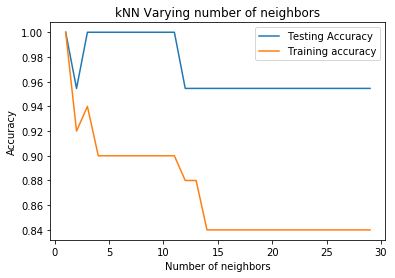

In [8]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [9]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=11)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 1.0


               precision    recall  f1-score   support

    Attacked       1.00      1.00      1.00        21
      Normal       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [10]:
cv_results = None

# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=11)
    
    #train model with cv of 5
    cv_scores = cross_val_score(knn_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['KNN'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['KNN'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [8]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.8604651162790697


               precision    recall  f1-score   support

    Attacked       0.97      0.87      0.92        38
      Normal       0.44      0.80      0.57         5

   micro avg       0.86      0.86      0.86        43
   macro avg       0.71      0.83      0.74        43
weighted avg       0.91      0.86      0.88        43



We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [11]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create SVM Classifier
    svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel
    
    #train model with cv of 5
    cv_scores = cross_val_score(svm_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['SVM'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['SVM'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


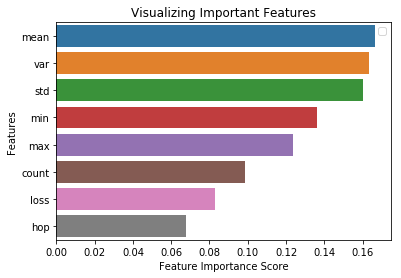

In [8]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Select relevant features

In [17]:
# separate features from target values
features = stats.drop(columns=['node_id', 'experiment', 'label', 'hop'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Gray Hole', 'Black Hole'}


Predicted values

In [12]:
#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.9767441860465116


               precision    recall  f1-score   support

    Attacked       0.97      1.00      0.99        38
      Normal       1.00      0.80      0.89         5

   micro avg       0.98      0.98      0.98        43
   macro avg       0.99      0.90      0.94        43
weighted avg       0.98      0.98      0.98        43



We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [13]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label', 'hop'])
    target = trace['label'].values
    print('Targets: ' + str(set(target)))

    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100)
    
    #train model with cv of 5
    cv_scores = cross_val_score(rf_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['Random Forest'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['Random Forest'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Targets: {'Normal', 'Attacked'}
Computing trace 25
Targets: {'Normal', 'Attacked'}
Computing trace 50
Targets: {'Normal', 'Attacked'}
Computing trace 100
Targets: {'Normal', 'Attacked'}


# Results

Here we plot the average results for each model computed with cross validation

In [15]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,KNN,200,0.905714
1,KNN,25,0.893035
2,KNN,50,0.904636
3,KNN,100,0.943806
4,SVM,200,0.945714
5,SVM,25,0.900655
6,SVM,50,0.893864
7,SVM,100,0.901916
8,Random Forest,200,0.932381
9,Random Forest,25,0.904519
